https://velog.io/@choonsik_mom/LSTM-GRU%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%A3%BC%EA%B0%80-%EC%98%88%EC%B8%A1


In [42]:
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.nn import Parameter
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch import Tensor
from torch.utils.data import DataLoader


import math
from datetime import datetime

In [43]:
# GPU 세팅
# GPU가 활성화가 잘 되어 있는지 device 함수를 통해 확인토록 하자.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

cuda:0 is available


In [44]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import numpy as np
import pandas as pd

In [46]:
print(yf)

<module 'yfinance' from '/usr/local/lib/python3.7/dist-packages/yfinance/__init__.py'>


In [47]:
df_price = df = yf.download('005930.KS',
                     start='2022-01-01',
                     end='2022-05-31')
df_price.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98 entries, 2022-01-04 to 2022-05-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       98 non-null     float64
 1   High       98 non-null     float64
 2   Low        98 non-null     float64
 3   Close      98 non-null     float64
 4   Adj Close  98 non-null     float64
 5   Volume     98 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 5.4 KB


In [48]:
df_price.describe()

,Open,High,Low,Close,Adj Close,Volume
count,98.000000,98.000000,98.000000,98.000000,98.000000,9.800000e+01
mean,70965.306122,71347.959184,70446.938776,70847.959184,69723.537269,1.269242e+07
std,4010.015863,3900.732936,3870.432568,3889.033739,3685.392266,6.042882e+06
min,65100.000000,65500.000000,64500.000000,64800.000000,63966.660156,0.000000e+00
25%,67500.000000,68025.000000,67050.000000,67525.000000,66656.617188,1.082566e+07
50%,70050.000000,70350.000000,69750.000000,70050.000000,68891.757812,1.307725e+07
75%,74300.000000,74300.000000,73375.000000,74000.000000,72672.695312,1.573957e+07
max,79500.000000,79600.000000,78600.000000,78900.000000,77484.812500,3.794336e+07


In [49]:
df_price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,78800.0,79200.0,78300.0,78700.0,77288.398438,12427416
2022-01-05,78800.0,79000.0,76400.0,77400.0,76011.710938,25470640
2022-01-06,76700.0,77600.0,76600.0,76900.0,75520.679688,12931954
2022-01-07,78100.0,78400.0,77400.0,78300.0,76895.570312,15163757
2022-01-10,78100.0,78100.0,77100.0,78000.0,76600.953125,9947422


그래프를 그려 종가 추세를 확인해 본다.

Text(0, 0.5, 'price')

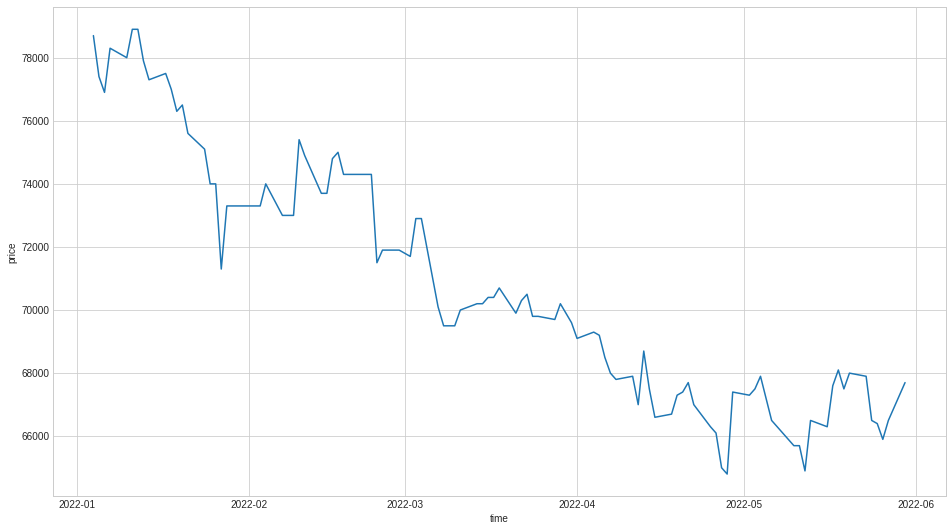

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(16, 9))
sns.lineplot(y=df_price['Close'], x=df_price.index) # .index => 인덱스 부분이 "Date"이기 때문
plt.xlabel('time')
plt.ylabel('price')

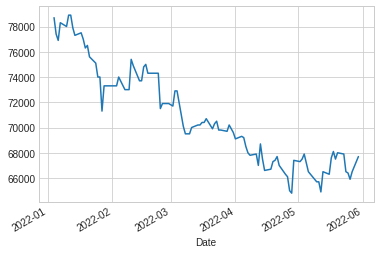

In [51]:
# data check
fig = df_price['Close'].plot()

데이터 셋을 target 기준으로 분리시켜주도록 한다.

In [52]:
# X, y 분리
X = df_price.drop('Close', axis=1) # Close 빼고 모든 값
y = df_price[['Close']] # Close 값만 포함

# 데이터를 train과 test로 나누자
train : test => 7 : 3

In [53]:
split_ratio = 0.7

total = len(df)
train = int(total * split_ratio)
test = total - train

print('전체 데이터 수: ', total)
print('train : ', train)
print('test : ', test)

SPLIT_SIZE = train # split으로 나누기 

전체 데이터 수:  98
train :  68
test :  30


*sklearn* 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalize 해주기.

표준화, 정규화 
https://wpaud16.tistory.com/67

In [54]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


ms = MinMaxScaler()   # 정규화  -> 모든 값을  0 ~ 1 사이 값으로 변경, 음수도 예외 없이 다 바꾼다. 
ss = StandardScaler() # 표준화  -> 평균 0, 분산 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:SPLIT_SIZE, :]
y_train = y_ms[:SPLIT_SIZE, :]

X_test = X_ss[SPLIT_SIZE:, :]
y_test = y_ms[SPLIT_SIZE:, :]

# (행 개수, 열 개수)
print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (68, 5) (68, 1)
Testing Shape : (30, 5) (30, 1)


데이터셋 형태를 tensor 형식으로 변경한다.

In [55]:
# 데이터셋 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, 
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (68, 5) (68, 1)
Testing Shape : (30, 5) (30, 1)


In [56]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes   # 클래스
        self.num_layers = num_layers     # LSTM 계층 개수
        self.input_size = input_size     # 입력 크기(컬럼 개수)
        self.hidden_size = hidden_size   # 은닉층의 뉴런 개수
        self.seq_length = seq_length     # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # lstm 계층
        self.fc_1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc = nn.Linear(128, num_classes) # 출력층

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉상태 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태 초기화
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size) # 완전연결층 적용을 위해 데이터 형태를 1차원으로 조정
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        return out

In [57]:
num_epochs = 2000
learning_rate = 0.0001

input_size  = 5 # input의 culumn 열 개수
hidden_size = 2 # 은닉층 유닛 개수
num_layers = 1 # LSTM 계층 개수

num_classes=1 # 클래스 개수

# LSTM 모델
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [58]:
for epoch in range(num_epochs) :
    outputs = lstm.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors) # 오차 계싼
    loss.backward() # 기울기 계산
    
    optimizer.step() # 오차 업데이트
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.17056
Epoch : 100, loss : 0.05373
Epoch : 200, loss : 0.02885
Epoch : 300, loss : 0.02096
Epoch : 400, loss : 0.01489
Epoch : 500, loss : 0.01039
Epoch : 600, loss : 0.00768
Epoch : 700, loss : 0.00619
Epoch : 800, loss : 0.00536
Epoch : 900, loss : 0.00483
Epoch : 1000, loss : 0.00442
Epoch : 1100, loss : 0.00405
Epoch : 1200, loss : 0.00372
Epoch : 1300, loss : 0.00342
Epoch : 1400, loss : 0.00316
Epoch : 1500, loss : 0.00292
Epoch : 1600, loss : 0.00270
Epoch : 1700, loss : 0.00249
Epoch : 1800, loss : 0.00228
Epoch : 1900, loss : 0.00209


모델 학습을 진행한다.

In [59]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

결과 출력을 위해 데이터를 변형한다.

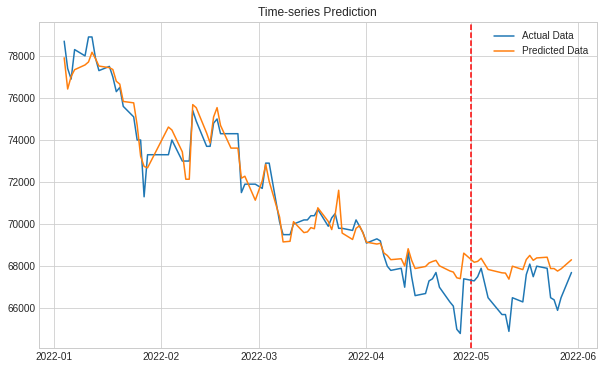

In [60]:
lstm.eval()
train_predict = lstm(df_x_ss)

predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

# 그래프 그리기
plt.figure(figsize=(10, 6))

# test 데이터
plt.axvline(x=datetime(2022,5,1), c='r', linestyle='--') #빨간 선 그리기

df['pred'] = predicted
plt.plot(df['Close'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()